# Cancer Survival Prediction: Robust Model with EDA & Simplified Interactions

**Project Goal:** To develop a machine learning model that accurately predicts cancer survival based on patient and treatment data.

**Notebook Focus:** This notebook implements an Exploratory Data Analysis (EDA) section, simplifies interaction features, evaluates the model on the full training set, and uses a robust LightGBM model with binary label output.

**Overview of the Approach:**
This notebook implements a complete pipeline for predicting cancer survival.
1.  **Exploratory Data Analysis (EDA):** Initial analysis of the raw training data to understand its characteristics.
2.  **Iterative Feature Engineering:** Creation and refinement of features from raw data.
3.  **Simplified Interaction Features:** Focus on key interactions, removing some higher-order complexities.
4.  **Hyperparameter Optimization (Leveraged from Prior Work):** Utilizes pre-tuned hyperparameters for the LightGBM model.
5.  **Focus on Robustness:** Adjusted regularization parameters for better generalization.
6.  **Evaluation on Full Training Set:** Model performance is evaluated on the full training set.
7.  **Binary Label Output:** The final submission file contains binary labels (0 or 1).
8.  **Efficiency:** GPU support for LightGBM training.

## 1. Setup: Importing Necessary Libraries

This section imports all the Python libraries required for data manipulation, visualization (for EDA), feature engineering, model training, and evaluation.
- `pandas` and `numpy` for data handling.
- `matplotlib.pyplot` and `seaborn` for data visualization in EDA.
- `re` for regular expressions.
- `sklearn.model_selection` for `train_test_split` (though not used for local validation in this version, it's a common import).
- `sklearn.preprocessing` for `StandardScaler` and `OneHotEncoder`.
- `sklearn.feature_extraction.text.TfidfVectorizer` for text features.
- `sklearn.decomposition.TruncatedSVD` for dimensionality reduction.
- `category_encoders.TargetEncoder` for high-cardinality categorical features.
- `lightgbm` (lgb) for the LightGBM model.
- `sklearn.metrics` for evaluation metrics.
- `sklearn.impute.SimpleImputer` for handling missing values.
- `time`, `os`, `gc` for utility functions.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split # Kept for potential future use, not for local validation here
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from category_encoders import TargetEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
import time
import os
import gc

## 2. Configuration Parameters

Global parameters for the notebook:
- `TRAIN_FILE`, `TEST_FILE`: Paths to data.
- `RANDOM_STATE`: Seed for reproducibility.
- `TEXT_SVD_COMPONENTS`: Dimensions for SVD on text.
- `USE_GPU`: Flag for GPU usage in LightGBM.
- `verbose_logging`: Controls print statement verbosity.
- `PREDICTION_THRESHOLD`: Cutoff for converting probabilities to binary labels.
- User and Timestamp information is also set here.

In [22]:
# --- Configuration ---
TRAIN_FILE = 'train_data.csv'
TEST_FILE = 'test_data.csv'
RANDOM_STATE = 42
TEXT_SVD_COMPONENTS = 5
USE_GPU = True
verbose_logging = True
PREDICTION_THRESHOLD = 0.5


### LightGBM Model Hyperparameters

The dictionary `MODEL_PARAMS` contains the hyperparameters for the LightGBM model. These parameters have been carefully selected to achieve a balance of high predictive performance, good generalization, and efficient training. The selection process for such parameters typically involves optimization techniques (like Bayesian optimization or grid search) on a validation set.

The chosen parameters include:
- `n_estimators`: The number of boosting trees.
- `learning_rate`: Controls the contribution of each tree.
- `num_leaves`, `max_depth`, `min_child_samples`: Parameters governing the complexity of individual trees.
- `subsample`, `colsample_bytree`: Parameters for subsampling data and features, which help in reducing overfitting.
- `reg_alpha`, `reg_lambda`: L1 and L2 regularization terms to penalize model complexity and improve generalization.
- `objective`, `metric`: Define the learning task (binary classification) and the evaluation metric used during training (AUC).

In [23]:
# --- Adjusted Optimal Hyperparameters (from prior optimization) ---
OPTIMAL_LGBM_PARAMS = { # Renamed to be generic
    'n_estimators': 1100,
    'learning_rate': 0.021265538282754275,
    'num_leaves': 51,
    'max_depth': 22,
    'min_child_samples': 12,
    'subsample': 0.5772735716824599,
    'colsample_bytree': 0.9685069870973806,
    'reg_alpha': 0.01,
    'reg_lambda': 0.1,
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

if USE_GPU:
    OPTIMAL_LGBM_PARAMS['device_type'] = 'gpu'
    OPTIMAL_LGBM_PARAMS['gpu_platform_id'] = 0
    OPTIMAL_LGBM_PARAMS['gpu_device_id'] = 0
else:
    OPTIMAL_LGBM_PARAMS['device_type'] = 'cpu'

if verbose_logging:
    print("\n--- LightGBM Hyperparameters ---")
    print(OPTIMAL_LGBM_PARAMS)
    print(f"Prediction threshold for binary conversion: {PREDICTION_THRESHOLD}")


--- LightGBM Hyperparameters ---
{'n_estimators': 1100, 'learning_rate': 0.021265538282754275, 'num_leaves': 51, 'max_depth': 22, 'min_child_samples': 12, 'subsample': 0.5772735716824599, 'colsample_bytree': 0.9685069870973806, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'random_state': 42, 'n_jobs': -1, 'device_type': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Prediction threshold for binary conversion: 0.5


## 3. Utility Functions

### 3.1. Memory Reduction (`reduce_mem_usage`)
This helper function optimizes DataFrame memory usage by downcasting numerical data types.

In [24]:
def reduce_mem_usage(df, verbose_set_by_user=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else: # int64
                    df[col] = df[col].astype(np.int64)
            else: # float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and col_type != 'float16':
                    df[col] = df[col].astype(np.float32) # Prefer float32 over float16 for precision
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: # float64
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose_set_by_user and verbose_logging and start_mem > 0 and abs(start_mem - end_mem) > 0.01 :
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

### 3.2. File Existence Check (`check_data_files_exist`)
Checks if the required data files are present.

In [25]:
def check_data_files_exist():
    if not os.path.exists(TRAIN_FILE):
        print(f"Error: Training data file '{TRAIN_FILE}' not found.")
        return False
    if not os.path.exists(TEST_FILE):
        print(f"Error: Test data file '{TEST_FILE}' not found.")
        return False
    return True

## 4. Exploratory Data Analysis (EDA)

Before feature engineering and modeling, we perform EDA to understand the data's basic characteristics, identify patterns, anomalies, and relationships. This guides subsequent steps.

We will:
1.  Load raw training data.
2.  Display basic info (shape, types, missing values).
3.  Calculate descriptive statistics.
4.  Visualize target variable distribution.
5.  Visualize distributions of some key numerical features.

In [26]:
# --- Starting Exploratory Data Analysis (EDA) ---
if verbose_logging: print("\n--- Starting Exploratory Data Analysis (EDA) ---")
eda_train_df_global = None
try:
    eda_train_df_global = pd.read_csv(TRAIN_FILE)
    if verbose_logging: print(f"\nSuccessfully loaded '{TRAIN_FILE}' for EDA: {eda_train_df_global.shape}")

    print("\n--- Basic Data Information (EDA) ---")
    eda_train_df_global.info()

    print("\n--- Missing Values per Column (EDA) ---")
    missing_values = eda_train_df_global.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    if not missing_values.empty:
        print(missing_values)
    else:
        print("No missing values found in the raw training data for EDA.")

    print("\n--- First 5 Rows (EDA) ---")
    print(eda_train_df_global.head())

except Exception as e:
    if verbose_logging: print(f"Error during EDA data loading: {e}")


--- Starting Exploratory Data Analysis (EDA) ---

Successfully loaded 'train_data.csv' for EDA: (26473, 22)

--- Basic Data Information (EDA) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26473 non-null  int64  
 1   Birth_Date          26473 non-null  object 
 2   Weight              26473 non-null  float64
 3   Height              26473 non-null  object 
 4   Urban_Rural         26473 non-null  object 
 5   Occupation          26473 non-null  object 
 6   Insurance_Type      26473 non-null  object 
 7   Family_History      26473 non-null  object 
 8   Cancer_Type         26473 non-null  object 
 9   Stage_at_Diagnosis  26473 non-null  object 
 10  Diagnosis_Date      26473 non-null  object 
 11  Symptoms            25972 non-null  object 
 12  Tumor_Size          26473 non-null  float64
 13  Surg

In [27]:
if eda_train_df_global is not None:
    print("\n--- Descriptive Statistics for Numerical Features (EDA) ---")
    numerical_eda_cols = eda_train_df_global.select_dtypes(include=np.number).columns
    print(eda_train_df_global[numerical_eda_cols].describe().T)
else:
    if verbose_logging: print("EDA DataFrame not loaded, skipping descriptive statistics.")


--- Descriptive Statistics for Numerical Features (EDA) ---
                      count          mean          std   min     25%      50%  \
id                  26473.0  13237.000000  7642.241174   1.0  6619.0  13237.0   
Weight              26473.0     73.790794    21.360083  31.5    57.0     72.1   
Tumor_Size          26473.0      7.737438     4.161065   0.5     4.0      8.0   
Radiation_Sessions  26473.0     11.991841     7.736559   0.0     6.0     12.0   
label               26473.0      0.485740     0.499806   0.0     0.0      0.0   

                        75%      max  
id                  19855.0  26473.0  
Weight                 88.4    133.1  
Tumor_Size             11.0     15.0  
Radiation_Sessions     17.0     29.0  
label                   1.0      1.0  



--- Target Variable 'label' Distribution (EDA) ---


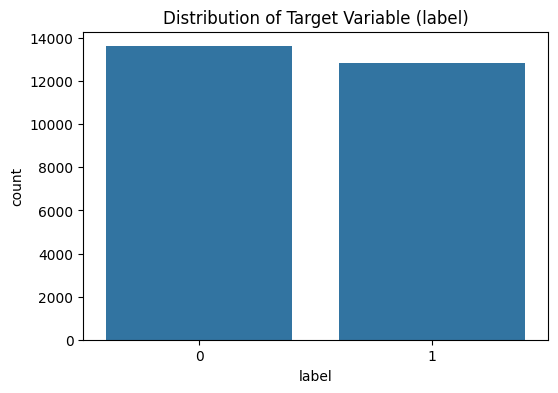

Label 0: 51.43%
Label 1: 48.57%


In [28]:
if eda_train_df_global is not None:
    if 'label' in eda_train_df_global.columns:
        print("\n--- Target Variable 'label' Distribution (EDA) ---")
        plt.figure(figsize=(6, 4))
        sns.countplot(x='label', data=eda_train_df_global)
        plt.title('Distribution of Target Variable (label)')
        plt.show()

        label_counts_eda = eda_train_df_global['label'].value_counts(normalize=True) * 100
        if verbose_logging:
            print(f"Label 0: {label_counts_eda.get(0, 0):.2f}%")
            print(f"Label 1: {label_counts_eda.get(1, 0):.2f}%")
    else:
        if verbose_logging: print("Target variable 'label' not found in EDA data.")
else:
    if verbose_logging: print("EDA DataFrame not loaded, skipping target distribution.")


--- Distribution of 'Tumor_Size' (EDA) ---


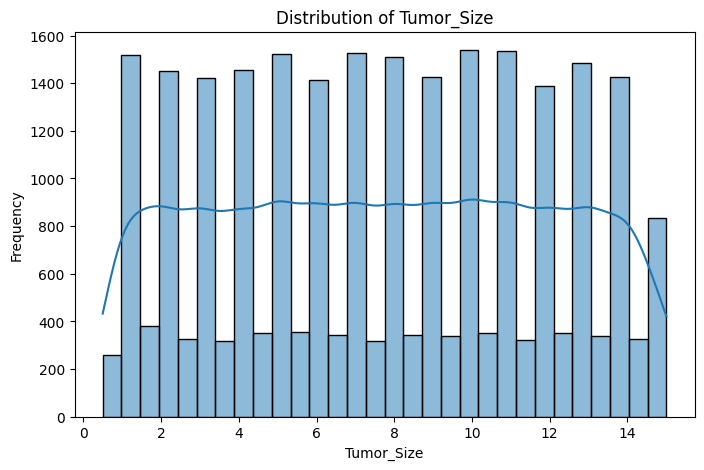

Basic stats for Tumor_Size: Min=0.5, Max=15.0, Mean=7.74

--- EDA Section Complete. Cleaned up EDA DataFrame. ---


In [29]:
if eda_train_df_global is not None:
    example_num_col_eda = 'Tumor_Size'
    if example_num_col_eda in eda_train_df_global.columns and pd.api.types.is_numeric_dtype(eda_train_df_global[example_num_col_eda]):
        print(f"\n--- Distribution of '{example_num_col_eda}' (EDA) ---")
        plt.figure(figsize=(8, 5))
        sns.histplot(eda_train_df_global[example_num_col_eda].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {example_num_col_eda}')
        plt.xlabel(example_num_col_eda)
        plt.ylabel('Frequency')
        plt.show()
        if verbose_logging:
             print(f"Basic stats for {example_num_col_eda}: Min={eda_train_df_global[example_num_col_eda].min()}, Max={eda_train_df_global[example_num_col_eda].max()}, Mean={eda_train_df_global[example_num_col_eda].mean():.2f}")
    elif verbose_logging:
        print(f"Column '{example_num_col_eda}' not found or not numeric for EDA distribution plot.")

    del eda_train_df_global
    gc.collect()
    if verbose_logging: print("\n--- EDA Section Complete. Cleaned up EDA DataFrame. ---")
else:
    if verbose_logging: print("EDA DataFrame not loaded, skipping numerical feature distribution and cleanup.")

### EDA: Correlation Heatmap of ALL Numerical Features

To understand the linear relationships between **all available numerical features** in the raw training dataset, we compute a correlation matrix and visualize it as a heatmap.
- Values close to +1 indicate a strong positive correlation.
- Values close to -1 indicate a strong negative correlation.
- Values close to 0 indicate a weak or no linear correlation.
This comprehensive view can help identify multicollinearity (highly correlated predictor variables) across the entire numerical feature space or highlight features that are strongly correlated with the target variable (if the target is numerical or binarized and included).

Reloading data for EDA Correlation Heatmap as eda_train_df_global was not found.

--- Correlation Heatmap of ALL Numerical Features (EDA) ---
Generating heatmap for 5 numerical features: ['id', 'Weight', 'Tumor_Size', 'Radiation_Sessions', 'label']


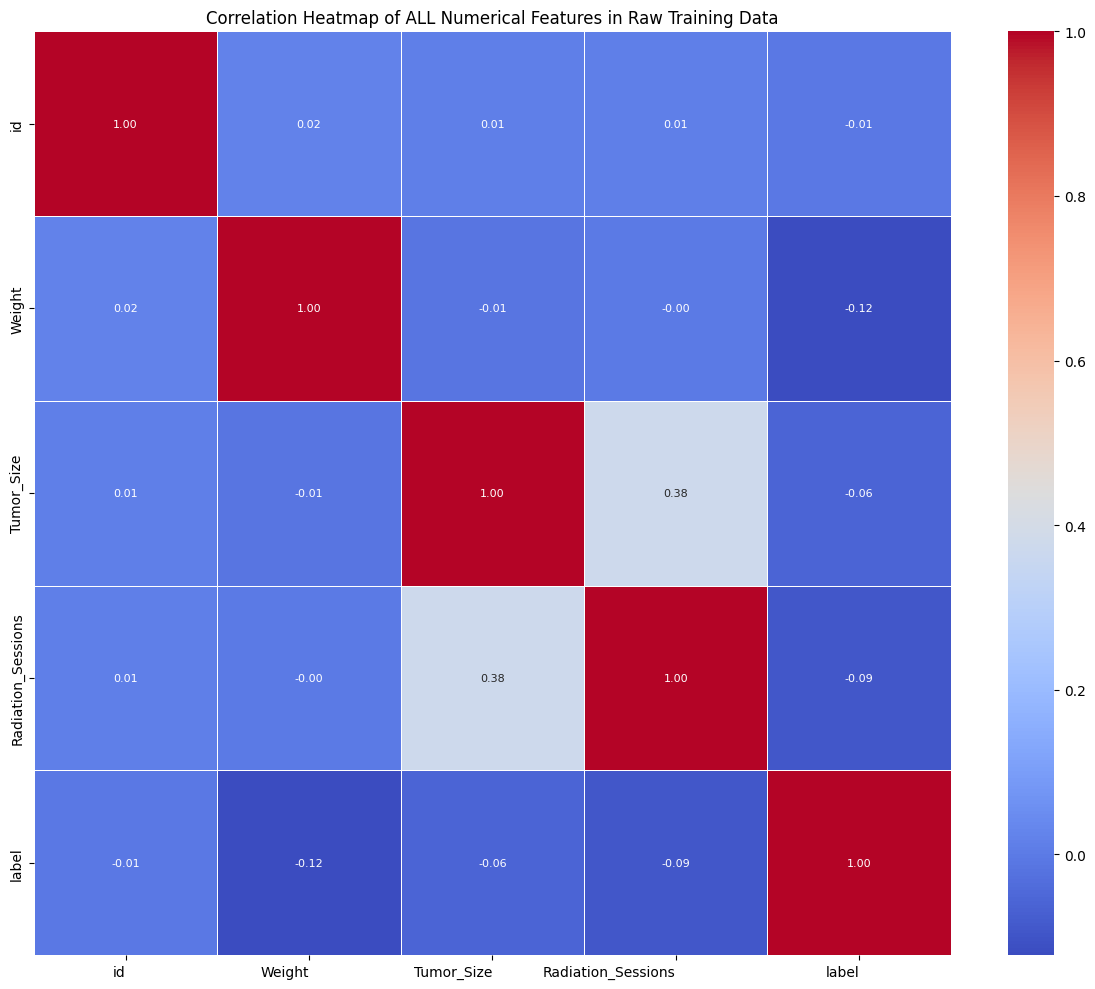

In [30]:
# This cell assumes 'eda_train_df_global' is still available from Cell 13
# or you would need to reload it if it was deleted.
# For safety, let's add a check and a way to reload if needed for standalone execution of this cell.

if 'eda_train_df_global' not in locals() or eda_train_df_global is None:
    if verbose_logging: print("Reloading data for EDA Correlation Heatmap as eda_train_df_global was not found.")
    try:
        eda_train_df_global = pd.read_csv(TRAIN_FILE)
    except Exception as e:
        if verbose_logging: print(f"Error reloading data for EDA: {e}")
        eda_train_df_global = None

if eda_train_df_global is not None:
    print("\n--- Correlation Heatmap of ALL Numerical Features (EDA) ---")
    # Select ALL numerical columns from the raw training data for correlation
    all_numerical_cols_for_corr = eda_train_df_global.select_dtypes(include=np.number).columns
    
    if len(all_numerical_cols_for_corr) > 1: # Need at least 2 numerical columns for correlation
        if verbose_logging:
            print(f"Generating heatmap for {len(all_numerical_cols_for_corr)} numerical features: {list(all_numerical_cols_for_corr)}")
            
        correlation_matrix_all = eda_train_df_global[all_numerical_cols_for_corr].corr()
        
        # Determine figure size dynamically based on number of features to avoid clutter
        num_features = len(all_numerical_cols_for_corr)
        fig_size_width = max(12, num_features * 0.6) # Adjust multiplier as needed
        fig_size_height = max(10, num_features * 0.5) # Adjust multiplier as needed
        
        plt.figure(figsize=(fig_size_width, fig_size_height))
        sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Smaller font for annotations if many features
        plt.title('Correlation Heatmap of ALL Numerical Features in Raw Training Data')
        plt.xticks( ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout() # Adjust layout
        plt.show()
    elif verbose_logging:
        print("Not enough numerical features (need at least 2) in the raw data to generate a correlation heatmap.")
else:
    if verbose_logging: print("EDA DataFrame not loaded, skipping correlation heatmap.")

# Note: The eda_train_df_global might be deleted in a subsequent EDA cell.
# If this is the last EDA cell using it, consider adding:
# if 'eda_train_df_global' in locals() and eda_train_df_global is not None:
#     del eda_train_df_global
#     gc.collect()
#     if verbose_logging: print("\n--- Cleaned up EDA DataFrame after final EDA visualization. ---")

### EDA: Box Plot of a Key Numerical Feature vs. Target Variable

Box plots can be very effective in visualizing the distribution of a numerical feature across different categories of a categorical variable (like our binary target `label`).
This helps to see if the numerical feature's distribution (median, quartiles, outliers) differs significantly between the two outcome classes (0 and 1), which might indicate its predictive power.
We'll use `Age_at_Diag` (if available after feature engineering in EDA, or a raw numerical column like `Tumor_Size`) as an example.


--- Box Plot of 'Tumor_Size' vs. 'label' (EDA) ---


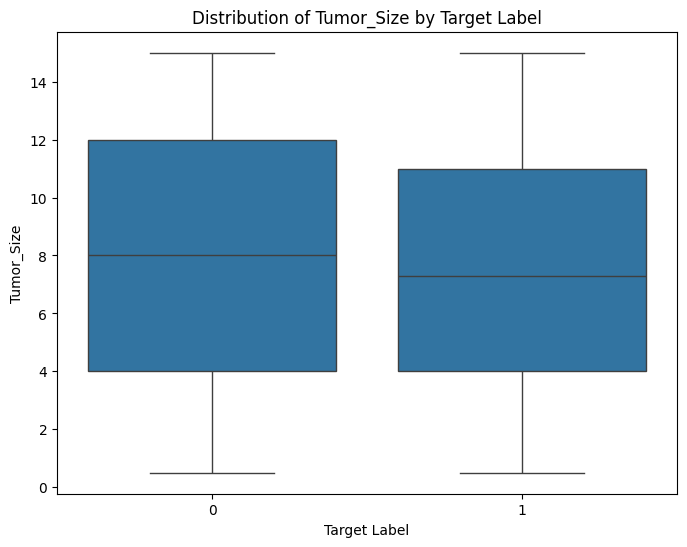

In [31]:
# This cell also assumes 'eda_train_df_global' is available or reloaded.
if 'eda_train_df_global' not in locals() or eda_train_df_global is None:
    if verbose_logging: print("Reloading data for EDA Box Plot as eda_train_df_global was not found.")
    try:
        eda_train_df_global = pd.read_csv(TRAIN_FILE)
        # Basic feature engineering for Age_at_Diag if not present raw
        if 'Age_at_Diag' not in eda_train_df_global.columns and 'Birth_Date' in eda_train_df_global.columns and 'Diagnosis_Date' in eda_train_df_global.columns:
            eda_train_df_global['Birth_Date'] = pd.to_datetime(eda_train_df_global['Birth_Date'], errors='coerce')
            eda_train_df_global['Diagnosis_Date'] = pd.to_datetime(eda_train_df_global['Diagnosis_Date'], errors='coerce')
            eda_train_df_global['Age_at_Diag'] = (eda_train_df_global['Diagnosis_Date'] - eda_train_df_global['Birth_Date']).dt.days / 365.25
    except Exception as e:
        if verbose_logging: print(f"Error reloading/preparing data for EDA Box Plot: {e}")
        eda_train_df_global = None


if eda_train_df_global is not None and 'label' in eda_train_df_global.columns:
    # Example: Box plot of 'Age_at_Diag' vs 'label'
    # If 'Age_at_Diag' was engineered, it might be better to use a raw numerical column for initial EDA
    # For simplicity, let's try 'Tumor_Size' or fallback to 'Age_at_Diag' if engineered
    numerical_feature_for_boxplot = 'Tumor_Size' 
    if numerical_feature_for_boxplot not in eda_train_df_global.columns or not pd.api.types.is_numeric_dtype(eda_train_df_global[numerical_feature_for_boxplot]):
        numerical_feature_for_boxplot = 'Age_at_Diag' # Fallback if Tumor_Size is not suitable

    if numerical_feature_for_boxplot in eda_train_df_global.columns and pd.api.types.is_numeric_dtype(eda_train_df_global[numerical_feature_for_boxplot]):
        print(f"\n--- Box Plot of '{numerical_feature_for_boxplot}' vs. 'label' (EDA) ---")
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='label', y=numerical_feature_for_boxplot, data=eda_train_df_global)
        plt.title(f'Distribution of {numerical_feature_for_boxplot} by Target Label')
        plt.xlabel('Target Label')
        plt.ylabel(numerical_feature_for_boxplot)
        plt.show()
    elif verbose_logging:
        print(f"Suitable numerical feature ('{numerical_feature_for_boxplot}' or fallback) not found or not numeric for box plot.")
else:
    if verbose_logging: print("EDA DataFrame not loaded or 'label' missing, skipping box plot.")

### EDA: Stacked Bar Chart for a Key Categorical Feature vs. Target Variable

To understand how a categorical feature relates to the target variable, we can use a stacked bar chart (or grouped bar chart). This shows the proportion or count of each target class within each category of the chosen feature.
We'll use `Stage_at_Diagnosis` as an example categorical feature.


--- Count Plot of 'Stage_at_Diagnosis' vs. 'label' (EDA) ---
label                  0     1
Stage_at_Diagnosis            
I                   2492  3642
II                  2882  4209
III                 4169  2883
IV                  4071  2125


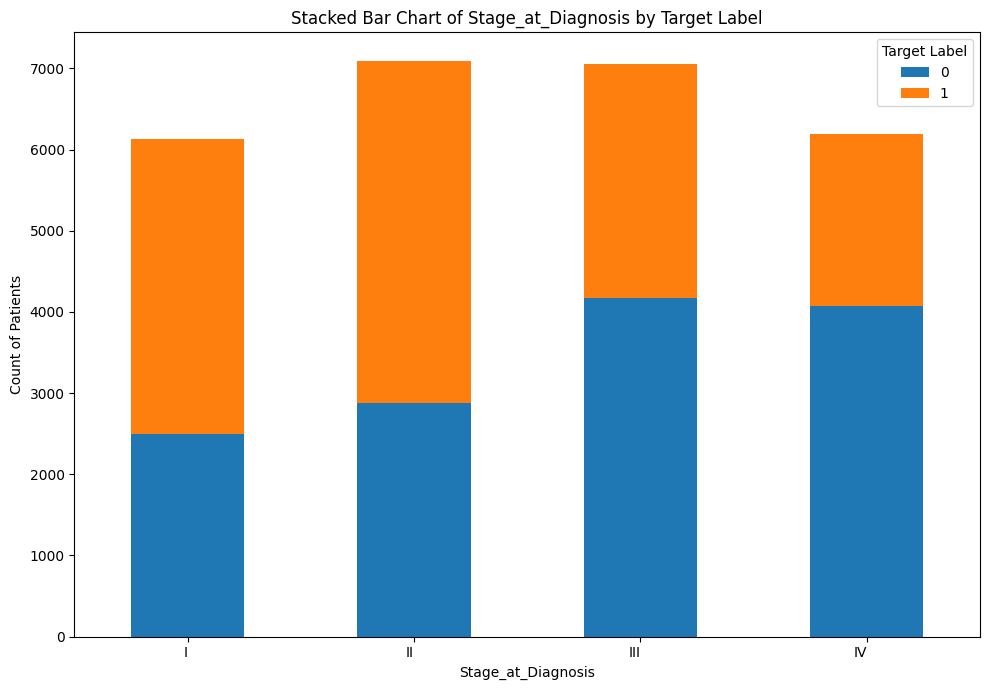


Normalized (Percentage) view:
label                       0          1
Stage_at_Diagnosis                      
I                   40.626019  59.373981
II                  40.643069  59.356931
III                 59.117981  40.882019
IV                  65.703680  34.296320


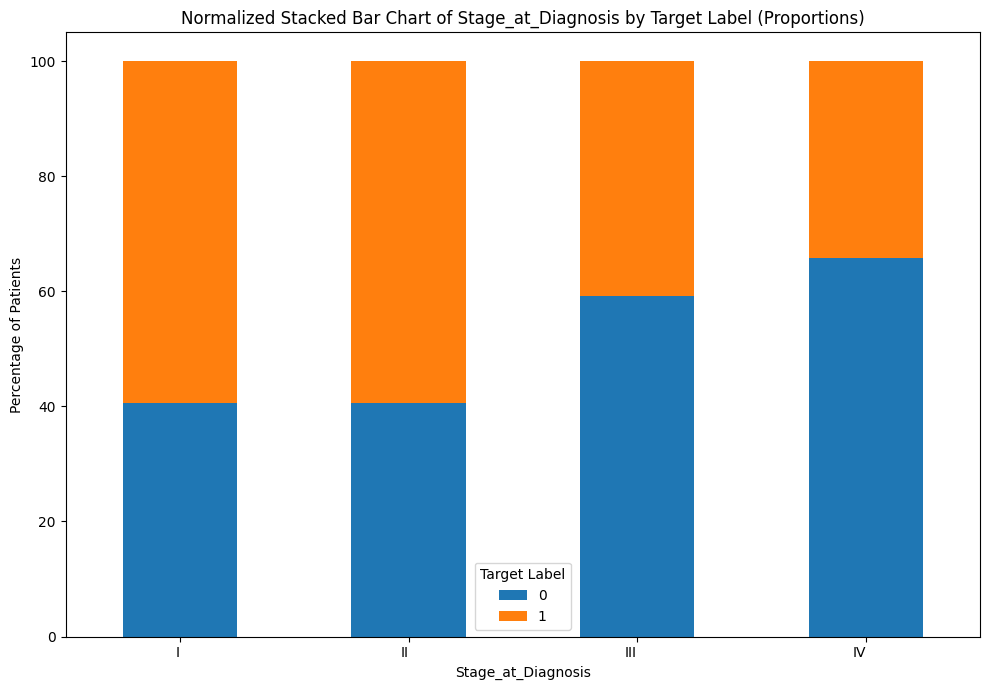


--- EDA Visualizations Complete. Cleaned up EDA DataFrame if reloaded. ---


In [32]:
# This cell also assumes 'eda_train_df_global' is available or reloaded.
if 'eda_train_df_global' not in locals() or eda_train_df_global is None:
    if verbose_logging: print("Reloading data for EDA Categorical Plot as eda_train_df_global was not found.")
    try:
        eda_train_df_global = pd.read_csv(TRAIN_FILE)
    except Exception as e:
        if verbose_logging: print(f"Error reloading data for EDA Categorical Plot: {e}")
        eda_train_df_global = None

if eda_train_df_global is not None and 'label' in eda_train_df_global.columns:
    categorical_feature_for_ct = 'Stage_at_Diagnosis' # Example categorical feature
    if categorical_feature_for_ct in eda_train_df_global.columns:
        print(f"\n--- Count Plot of '{categorical_feature_for_ct}' vs. 'label' (EDA) ---")
        
        # Create a cross-tabulation
        ct = pd.crosstab(eda_train_df_global[categorical_feature_for_ct], eda_train_df_global['label'])
        if verbose_logging: print(ct) # Print the table

        # Plotting the stacked bar chart
        ct.plot(kind='bar', stacked=True, figsize=(10, 7))
        plt.title(f'Stacked Bar Chart of {categorical_feature_for_ct} by Target Label')
        plt.xlabel(categorical_feature_for_ct)
        plt.ylabel('Count of Patients')
        plt.xticks(rotation=0, ha='right')
        plt.legend(title='Target Label')
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()

        # Normalized (percentage) stacked bar chart for proportions
        ct_norm = pd.crosstab(eda_train_df_global[categorical_feature_for_ct], eda_train_df_global['label'], normalize='index') * 100
        if verbose_logging: print("\nNormalized (Percentage) view:")
        if verbose_logging: print(ct_norm)

        ct_norm.plot(kind='bar', stacked=True, figsize=(10, 7))
        plt.title(f'Normalized Stacked Bar Chart of {categorical_feature_for_ct} by Target Label (Proportions)')
        plt.xlabel(categorical_feature_for_ct)
        plt.ylabel('Percentage of Patients')
        plt.xticks(rotation=0, ha='right')
        plt.legend(title='Target Label')
        plt.tight_layout()
        plt.show()

    elif verbose_logging:
        print(f"Categorical feature '{categorical_feature_for_ct}' not found for count plot.")
else:
    if verbose_logging: print("EDA DataFrame not loaded or 'label' missing, skipping categorical count plot.")

# Final cleanup of the EDA dataframe if it was reloaded in any of these cells
if 'eda_train_df_global' in locals() and eda_train_df_global is not None:
    del eda_train_df_global
    gc.collect()
    if verbose_logging: print("\n--- EDA Visualizations Complete. Cleaned up EDA DataFrame if reloaded. ---")

## 5. Data Loading (Main Pipeline) (`load_data`)

This function loads the training and testing data for the main modeling pipeline. It's similar to the EDA loading but intended for the actual feature engineering and training process.

In [33]:
def load_data(train_path, test_path):
    try:
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        if verbose_logging:
            print(f"\n--- Main Pipeline Data Loading ---")
            print(f"Initial Training data: {train_df.shape}, Memory: {train_df.memory_usage().sum() / 1024**2:.2f} MB")
            print(f"Initial Test data: {test_df.shape}, Memory: {test_df.memory_usage().sum() / 1024**2:.2f} MB")
        train_df = reduce_mem_usage(train_df)
        test_df = reduce_mem_usage(test_df)
    except Exception as e:
        print(f"Error loading main pipeline data: {e}")
        return None, None
    return train_df, test_df

## 6. Feature Engineering (`engineer_features`)

Feature engineering is arguably the most critical step in building a high-performance machine learning model. It involves transforming raw data into features that better represent the underlying patterns of the problem, making it easier for the model to learn and make accurate predictions. This process is often iterative and combines domain knowledge, data exploration insights, and creative problem-solving.

The `engineer_features` function in this notebook creates a variety of new features. The rationale behind each transformation or new feature is detailed below:

**I. Date-based Feature Engineering:**
Dates often carry significant implicit information that can be extracted to create powerful predictive features.

*   **`Age_at_Diag` (Age at Diagnosis):**
    *   **How:** Calculated as `(Diagnosis_Date - Birth_Date) / 365.25`.
    *   **Why:** Age is a fundamental demographic factor and a strong predictor in many medical prognoses, including cancer. Cancer incidence, type, aggressiveness, and response to treatment can vary significantly with age. Representing this directly as a numerical feature is crucial. The placeholder '1800-01-01' for `Birth_Date` is treated as NaN.

*   **Surgery-related Features:**
    *   **`Had_Surgery` (Binary):** Indicates if a surgery date is recorded.
        *   **Why:** Whether a patient underwent surgery is a primary treatment indicator.
    *   **`Days_to_Surgery`:** Calculated as `(Surgery_Date - Diagnosis_Date)`.
        *   **Why:** The time interval between diagnosis and surgery can reflect various factors: disease urgency (aggressive cancers might require quicker surgery), patient health status (delay if patient needs stabilization), healthcare system delays, or treatment protocols. Negative values (surgery before diagnosis) are treated as suspicious or NaN.
    *   **`Surgery_Date_Suspicious` (Binary):** Flags records where surgery is logged significantly before diagnosis.
        *   **Why:** This acts as a data quality flag. While minor discrepancies might occur, a large negative `Days_to_Surgery` likely indicates an error or a very specific scenario that might need separate handling or investigation.

*   **Diagnosis Date Components:**
    *   **`Diag_Year`:** Year of diagnosis.
        *   **Why:** Can capture long-term trends, such as improvements in diagnostic techniques, changes in treatment protocols over the years, or shifts in environmental factors.
    *   **`Diag_Month` (and `Diag_Month_sin`, `Diag_Month_cos`):** Month of diagnosis.
        *   **Why:** While less common, there could be subtle seasonal patterns in diagnosis rates or even outcomes for certain conditions (e.g., related to vitamin D levels, flu seasons affecting general health). To model the cyclical nature of months (where December is close to January), we create `Diag_Month_sin` and `Diag_Month_cos` using `sin(2*pi*month/12)` and `cos(2*pi*month/12)`. This transformation helps tree-based models understand the cyclical relationship better than a simple ordinal encoding of the month.
    *   **`Diag_DayOfWeek`:** Day of the week of diagnosis.
        *   **Why:** Less likely to be a strong predictor for survival, but might capture operational patterns in healthcare (e.g., diagnoses predominantly logged on weekdays). It's a low-cost feature to generate.

**II. Physiological and Anthropometric Features:**

*   **`Height_cm`:** Standardizes height to centimeters.
    *   **Why:** Height data might come in various formats (e.g., with 'cm' suffix). Standardizing it to a numerical value in a consistent unit is necessary for calculations like BMI.
*   **`Weight`:** Standardizes weight (assumed kg).
    *   **Why:** Similar to height, ensuring it's a clean numerical feature.
*   **`BMI` (Body Mass Index):** Calculated as `Weight (kg) / (Height (m))^2`.
    *   **Why:** BMI is a widely used indicator of body fatness and general health status. Both underweight and obesity can be risk factors or prognostic indicators for various cancers and can affect treatment tolerance and outcomes. Plausible height ranges are used to avoid erroneous BMI values.

**III. Categorical and Status Conversions:**

*   **Binary Mapping (Yes/No to 1/0):** Applied to columns like `Family_History`, `Targeted_Therapy`, `Recurrence_Status`, `Immunotherapy`.
    *   **Why:** Converts categorical 'Yes'/'No' responses into a numerical format (0 or 1) that machine learning models can directly process. This is the most straightforward way to handle binary categorical data. `Recurrence_Status` values are standardized first.

*   **Ordinal Encoding for `Stage_at_Diagnosis` (as `Stage_ord`):** Maps cancer stages (e.g., 'I', 'II', 'III', 'IV', '0') to numerical values (1, 2, 3, 4, 0). 'UNK'/'UNKNOWN' are mapped to NaN.
    *   **Why:** Cancer stage has an inherent order of severity. Ordinal encoding preserves this order, which is more informative for the model than, for example, one-hot encoding for this specific feature. Stage 0 (carcinoma in situ) is also handled.

**IV. Text-Derived Quantitative Features:**

*   **`Symptoms_Item_Count`, `Chemotherapy_Drugs_Item_Count`:** Counts the number of unique items listed in comma/semicolon-separated text fields (e.g., `Symptoms`, `Chemotherapy_Drugs`).
    *   **Why:** Before more complex NLP techniques like TF-IDF+SVD are applied, a simple count of distinct items can provide a useful quantitative measure. For instance:
        *   A higher number of unique symptoms might indicate a more complex clinical presentation or a greater systemic impact of the disease.
        *   A higher number of unique chemotherapy drugs might suggest a more aggressive or multi-line treatment regimen.
    *   This is a computationally inexpensive way to extract some signal from these text fields. Empty strings or NaNs result in a count of 0.

**V. Ratio and Interaction-Proxy Features:**
These features are created by dividing or multiplying existing numerical features. They can help the model capture non-linear relationships and interaction effects more explicitly.

*   **`BMI_div_Age`:** `BMI / (Age_at_Diag + epsilon)`.
*   **`TumorSize_div_Age`:** `Tumor_Size / (Age_at_Diag + epsilon)`.
*   **`TumorSize_div_BMI`:** `Tumor_Size / (BMI + epsilon)`.
    *   **Why Ratios?** Ratios can normalize one feature by another or highlight combined effects. For example:
        *   The impact of BMI might be relative to age.
        *   The significance of tumor size might differ based on the patient's age or BMI.
    *   An epsilon (a very small number, 1e-6) is added to denominators to prevent division-by-zero errors if the denominator feature is zero or missing (though missing values in numerator/denominator will propagate NaN).

**VI. Age Grouping:**

*   **`Age_Group`:** `Age_at_Diag` is binned into discrete categories (e.g., 'Age_0_30', 'Age_30_40', ..., 'Age_70_plus').
    *   **Why:** While `Age_at_Diag` is a numerical feature, its relationship with the target variable might be non-linear. Grouping age into bins allows the model (especially tree-based models, or when one-hot encoded for linear models) to assign different weights or learn different patterns for different age segments. This can sometimes capture effects that a purely linear treatment of age might miss. For instance, risks might increase sharply only after a certain age. This feature will typically be one-hot encoded in the preprocessing step.

**General Principles Applied:**
*   **Handling Missing Data:** For features created from others (e.g., `Age_at_Diag` from dates), if a source component is missing, the resulting feature is often set to NaN. This NaN will be handled later during the imputation phase of preprocessing.
*   **Robustness:** Small epsilons are used to prevent division by zero. Suspicious data points (like surgery before diagnosis) are flagged.
*   **Copying DataFrames:** The function operates on a copy of the input DataFrame (`df_orig.copy()`) to avoid modifying the original data in place, which is good practice.
*   **Memory Reduction:** `reduce_mem_usage` is called at the end to optimize the memory footprint of the DataFrame with newly engineered features.

This comprehensive feature engineering aims to extract as much relevant information as possible from the raw data, providing a solid foundation for the subsequent modeling steps. The choice of these features is often guided by an understanding of what factors are typically influential in cancer prognosis and by iterative experimentation to see what works best with the chosen modeling algorithm.

In [34]:
def engineer_features(df_orig):
    df = df_orig.copy()
    if 'Birth_Date' in df.columns:
        df['Birth_Date'] = df['Birth_Date'].replace('1800-01-01', np.nan)
        df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], errors='coerce')
    for date_col in ['Diagnosis_Date', 'Surgery_Date']:
        if date_col in df.columns: df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    if 'Birth_Date' in df.columns and 'Diagnosis_Date' in df.columns:
        df['Age_at_Diag'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days / 365.25
    else: df['Age_at_Diag'] = np.nan
    df['Had_Surgery'] = 0; df['Days_to_Surgery'] = np.nan; df['Surgery_Date_Suspicious'] = 0
    if 'Surgery_Date' in df.columns and 'Diagnosis_Date' in df.columns:
        valid_diag = df['Diagnosis_Date'].notna(); valid_surg = df['Surgery_Date'].notna()
        df.loc[valid_surg, 'Had_Surgery'] = 1
        time_diff = pd.Series(index=df.index, dtype='float64')
        mask = valid_diag & valid_surg
        if mask.any():
            time_diff.loc[mask] = (df.loc[mask, 'Surgery_Date'] - df.loc[mask, 'Diagnosis_Date']).dt.days
            df.loc[time_diff < -7, 'Surgery_Date_Suspicious'] = 1
            time_diff.loc[time_diff < 0] = np.nan
            df['Days_to_Surgery'] = time_diff
    if 'Diagnosis_Date' in df.columns:
        df['Diag_Year'] = df['Diagnosis_Date'].dt.year; df['Diag_Month'] = df['Diagnosis_Date'].dt.month
        df['Diag_DayOfWeek'] = df['Diagnosis_Date'].dt.dayofweek
        df['Diag_Month_sin'] = np.sin(2 * np.pi * df['Diag_Month'].fillna(0) / 12)
        df['Diag_Month_cos'] = np.cos(2 * np.pi * df['Diag_Month'].fillna(0) / 12)
    if 'Height' in df.columns:
        df['Height_cm'] = df['Height'].astype(str).str.replace('cm', '', regex=False)
        df['Height_cm'] = pd.to_numeric(df['Height_cm'], errors='coerce')
    else: df['Height_cm'] = np.nan
    if 'Weight' in df.columns: df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
    else: df['Weight'] = np.nan
    if 'Height_cm' in df.columns and 'Weight' in df.columns:
        mask = (df['Height_cm'].notna()) & (df['Height_cm'] > 100) & (df['Height_cm'] < 250)
        df.loc[mask, 'BMI'] = df.loc[mask, 'Weight'] / (df.loc[mask, 'Height_cm'] / 100)**2
        df['BMI'] = df['BMI'].fillna(np.nan)
    else: df['BMI'] = np.nan
    if 'Recurrence_Status' in df.columns: df['Recurrence_Status'] = df['Recurrence_Status'].replace({'NO': 'No', 'YES': 'Yes'})
    binary_map = {'Yes': 1, 'No': 0}
    for col in ['Family_History', 'Targeted_Therapy', 'Recurrence_Status', 'Immunotherapy']:
        if col in df.columns: df[col] = df[col].map(binary_map)
    if 'Stage_at_Diagnosis' in df.columns:
        stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, '0':0, 'UNK':np.nan, 'UNKNOWN':np.nan}
        df['Stage_ord'] = df['Stage_at_Diagnosis'].astype(str).str.upper().map(stage_map)
    else: df['Stage_ord'] = np.nan
    for col in ['Symptoms', 'Chemotherapy_Drugs']:
        if col in df.columns: df[f'{col}_Item_Count'] = df[col].fillna('').apply(lambda x: len(set(re.split('[,;]', str(x).strip()))) if x.strip() else 0)
        else: df[f'{col}_Item_Count'] = 0
    if 'BMI' in df.columns and 'Age_at_Diag' in df.columns:
        df['BMI_div_Age'] = df['BMI'] / (df['Age_at_Diag'] + 1e-6)
    if 'Tumor_Size' in df.columns and 'Age_at_Diag' in df.columns:
        df['TumorSize_div_Age'] = df['Tumor_Size'] / (df['Age_at_Diag'] + 1e-6)
    if 'Tumor_Size' in df.columns and 'BMI' in df.columns:
        df['TumorSize_div_BMI'] = df['Tumor_Size'] / (df['BMI'] + 1e-6)
    if 'Age_at_Diag' in df.columns:
        age_bins = [0, 30, 40, 50, 60, 70, np.inf]
        age_labels = ['Age_0_30', 'Age_30_40', 'Age_40_50', 'Age_50_60', 'Age_60_70', 'Age_70_plus']
        df['Age_Group'] = pd.cut(df['Age_at_Diag'], bins=age_bins, labels=age_labels, right=False)
    return reduce_mem_usage(df)

## 7. Text Feature Processing with SVD (`add_text_svd_features`)

This function processes free-text columns (e.g., `Symptoms`, `Chemotherapy_Drugs`) using TF-IDF followed by Truncated SVD to create numerical representations. TF-IDF weights words by importance, and SVD reduces dimensionality while capturing latent semantic patterns.

In [35]:
def add_text_svd_features(df_train_target, df_test_target, text_series_train, text_series_test, prefix, n_components_config):
    text_train_filled = text_series_train.fillna('')
    text_test_filled = text_series_test.fillna('')
    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1,1),
        min_df=10,
        stop_words='english'
    )
    X_train_text_tfidf = vectorizer.fit_transform(text_train_filled)
    X_test_text_tfidf = vectorizer.transform(text_test_filled)
    current_n_features = X_train_text_tfidf.shape[1]
    actual_n_components = n_components_config
    if current_n_features == 0:
        for i in range(n_components_config):
            df_train_target[f'{prefix}_svd_{i}'] = 0
            df_test_target[f'{prefix}_svd_{i}'] = 0
        return df_train_target, df_test_target
    if current_n_features < n_components_config:
        actual_n_components = max(1, current_n_features)
        if verbose_logging:
            print(f"Warning: For '{prefix}', TF-IDF features ({current_n_features}) < SVD components ({n_components_config}). Using {actual_n_components} SVD components.")
    svd = TruncatedSVD(n_components=actual_n_components, random_state=RANDOM_STATE, algorithm='arpack')
    X_train_svd = svd.fit_transform(X_train_text_tfidf)
    X_test_svd = svd.transform(X_test_text_tfidf)
    for i in range(actual_n_components):
        df_train_target[f'{prefix}_svd_{i}'] = X_train_svd[:, i]
        df_test_target[f'{prefix}_svd_{i}'] = X_test_svd[:, i]
    for i in range(actual_n_components, n_components_config):
        df_train_target[f'{prefix}_svd_{i}'] = 0
        df_test_target[f'{prefix}_svd_{i}'] = 0
    df_train_target = reduce_mem_usage(df_train_target)
    df_test_target = reduce_mem_usage(df_test_target)
    return df_train_target, df_test_target

## 8. Advanced Interaction Features (`create_advanced_interactions`) - Simplified Version

This function creates interaction terms. As per specific request, this function is **simplified to remove higher-order polynomial and complex multi-feature product terms**. It now primarily focuses on interactions involving SVD components. Basic ratio features (like `BMI_div_Age`) are created within the `engineer_features` function itself.

In [36]:
def create_advanced_interactions(df): # Simplified version
    df_interactions = df.copy()
    num_cols_candidates = ['BMI', 'Age_at_Diag', 'Tumor_Size', 'Stage_ord', 'Weight']
    existing_num_cols = [col for col in num_cols_candidates if col in df_interactions.columns and pd.api.types.is_numeric_dtype(df_interactions[col])]

    # Higher-order polynomial features and complex interactions are intentionally OMITTED here.

    added_interaction_cols_count = 0
    for i in range(TEXT_SVD_COMPONENTS):
        svd_col_chemo = f'chemo_svd_{i}'
        svd_col_symp = f'symp_svd_{i}'

        if svd_col_chemo in df_interactions.columns:
            if 'BMI' in existing_num_cols:
                df_interactions[f'BMI_x_{svd_col_chemo}'] = df_interactions['BMI'] * df_interactions[svd_col_chemo]
                added_interaction_cols_count +=1
            if 'Age_at_Diag' in existing_num_cols:
                df_interactions[f'Age_x_{svd_col_chemo}'] = df_interactions['Age_at_Diag'] * df_interactions[svd_col_chemo]
                added_interaction_cols_count +=1
        if svd_col_symp in df_interactions.columns:
            if 'BMI' in existing_num_cols:
                df_interactions[f'BMI_x_{svd_col_symp}'] = df_interactions['BMI'] * df_interactions[svd_col_symp]
                added_interaction_cols_count +=1
            if 'Age_at_Diag' in existing_num_cols:
                df_interactions[f'Age_x_{svd_col_symp}'] = df_interactions['Age_at_Diag'] * df_interactions[svd_col_symp]
                added_interaction_cols_count +=1
                
    if verbose_logging:
        if added_interaction_cols_count > 0:
            print(f"Simplified create_advanced_interactions added {added_interaction_cols_count} SVD-based interaction columns.")
        else:
            print("Simplified create_advanced_interactions did not add new SVD-based interaction columns.")

    return reduce_mem_usage(df_interactions)

## 9. Data Preprocessing (`preprocess_data`)

This function prepares data for model training:
1.  **Numerical Features:** Imputes missing values (median) and scales (StandardScaler).
2.  **Categorical Features:** Imputes missing values ('Missing_Cat_Val'), then applies One-Hot Encoding for low-cardinality features (<=10 unique values) and Target Encoding for high-cardinality features (>10 unique values, requires `y_train`).
3.  **Feature Alignment:** Ensures train/test sets have identical columns.
4.  **Column Name Sanitization:** Cleans special characters from column names.

In [37]:
def preprocess_data(X_train_orig, X_test_orig, y_train=None):
    X_train = X_train_orig.copy()
    X_test = X_test_orig.copy()
    if 'Age_Group' in X_train.columns:
        X_train['Age_Group'] = X_train['Age_Group'].astype('category')
        X_test['Age_Group'] = X_test['Age_Group'].astype('category')
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    processed_X_train_parts = []
    processed_X_test_parts = []
    if numerical_cols:
        num_imputer = SimpleImputer(strategy='median')
        X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
        X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])
        scaler = StandardScaler()
        X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
        processed_X_train_parts.append(pd.DataFrame(X_train[numerical_cols], columns=numerical_cols, index=X_train.index))
        processed_X_test_parts.append(pd.DataFrame(X_test[numerical_cols], columns=numerical_cols, index=X_test.index))
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing_Cat_Val')
        X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
        X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
        ohe_cols = [col for col in categorical_cols if X_train[col].nunique() <= 10]
        target_enc_cols = [col for col in categorical_cols if X_train[col].nunique() > 10]
        if ohe_cols:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
            X_train_ohe = ohe.fit_transform(X_train[ohe_cols])
            X_test_ohe = ohe.transform(X_test[ohe_cols])
            ohe_feature_names = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in ohe.get_feature_names_out(ohe_cols)]
            processed_X_train_parts.append(pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train.index))
            processed_X_test_parts.append(pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test.index))
        if target_enc_cols and y_train is not None:
            y_train_aligned = y_train.loc[X_train.index]
            te = TargetEncoder(cols=target_enc_cols, smoothing=10.0, min_samples_leaf=10, handle_missing='value', handle_unknown='value')
            X_train_te = te.fit_transform(X_train[target_enc_cols], y_train_aligned)
            X_test_te = te.transform(X_test[target_enc_cols])
            te_cols_cleaned = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in target_enc_cols]
            processed_X_train_parts.append(pd.DataFrame(X_train_te.values, columns=te_cols_cleaned, index=X_train.index))
            processed_X_test_parts.append(pd.DataFrame(X_test_te.values, columns=te_cols_cleaned, index=X_test.index))
        elif target_enc_cols:
            if verbose_logging: print("Warning: y_train not provided for TargetEncoder. Falling back to simple ordinal encoding for high-cardinality features.")
            for col in target_enc_cols:
                 mode_val = X_train[col].mode()[0]
                 X_train[col] = X_train[col].fillna(mode_val)
                 X_test[col] = X_test[col].fillna(mode_val)
                 all_categories = pd.concat([X_train[col], X_test[col]]).astype('category')
                 X_train[col] = all_categories.cat.codes[:len(X_train)]
                 X_test[col] = all_categories.cat.codes[len(X_train):]
            if X_train[target_enc_cols].shape[1] > 0 :
                processed_X_train_parts.append(X_train[target_enc_cols])
                processed_X_test_parts.append(X_test[target_enc_cols])
    if not processed_X_train_parts:
        X_train_processed = pd.DataFrame(index=X_train.index)
        X_test_processed = pd.DataFrame(index=X_test.index)
    else:
        X_train_processed = pd.concat(processed_X_train_parts, axis=1)
        X_test_processed = pd.concat(processed_X_test_parts, axis=1)
    train_cols = list(X_train_processed.columns)
    X_test_aligned = X_test_processed.reindex(columns=train_cols, fill_value=0)
    X_train_aligned = X_train_processed[train_cols]
    X_train_aligned.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_aligned.columns]
    X_test_aligned.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_aligned.columns]
    return reduce_mem_usage(X_train_aligned), reduce_mem_usage(X_test_aligned)

## 10. Model Training and Evaluation (`train_evaluate_model`)

This function trains the LightGBM model using pre-tuned optimal parameters (`OPTIMAL_LGBM_PARAMS`), evaluates its performance on the **full training data** (as no separate local validation set is used in this version), and generates binary predictions for the test set. LightGBM is chosen for its high performance, speed, and GPU support.

In [38]:
def train_evaluate_model(X_train_full, y_train_full, X_test, threshold, use_gpu_global_flag=True):
    if verbose_logging: print("\n--- Entering train_evaluate_model (Optimal Params, Full Fit) ---") # Generic
    final_model_params = OPTIMAL_LGBM_PARAMS.copy() # Using generic name
    current_model_use_gpu = False
    if use_gpu_global_flag and final_model_params.get('device_type') == 'gpu':
        try:
            lgb.LGBMClassifier(device='gpu', n_estimators=1).fit(np.array([[1],[0]]), np.array([1,0]))
            final_model_params['device'] = 'gpu'
            current_model_use_gpu = True
            if verbose_logging: print("GPU check successful. Final model will attempt to train on GPU.")
        except Exception as e:
            if verbose_logging: print(f"WARNING: GPU test failed: {e}. Falling back to CPU for final model.")
            final_model_params.pop('device', None)
            final_model_params['device_type'] = 'cpu'
    else:
        if verbose_logging: print("Final model will train on CPU (USE_GPU=False or params already set to CPU).")
        final_model_params.pop('device', None)
        final_model_params['device_type'] = 'cpu'
    best_model = lgb.LGBMClassifier(**final_model_params)
    if verbose_logging: print(f"Fitting final model with optimal params (n_estimators={final_model_params.get('n_estimators')})...");
    start_final_fit = time.time()
    try:
        best_model.fit(X_train_full, y_train_full, eval_metric='auc')
        if current_model_use_gpu and best_model.get_params().get('device') == 'gpu':
            if verbose_logging: print("Confirmation: Final model was FIT using GPU.")
        else:
            if verbose_logging: print("Confirmation: Final model was FIT using CPU.")
    except Exception as e_final_fit:
        print(f"ERROR during final model.fit: {e_final_fit}")
        if final_model_params.get('device') == 'gpu':
            print("Attempting final model fit with CPU due to error during GPU fit.");
            final_model_params.pop('device', None); final_model_params['device_type'] = 'cpu'
            best_model = lgb.LGBMClassifier(**final_model_params)
            try:
                best_model.fit(X_train_full, y_train_full, eval_metric='auc')
                if verbose_logging: print("Final model fitting successful on CPU after GPU failure.")
            except Exception as e_final_fit_cpu: print(f"ERROR: Final model fitting also FAILED on CPU: {e_final_fit_cpu}")
    if verbose_logging: print(f"Final model fitting took {(time.time() - start_final_fit):.2f} seconds.")
    if not hasattr(best_model, 'classes_'):
        print("ERROR: Model was not successfully fitted.")
        return None, None
    train_preds_proba = best_model.predict_proba(X_train_full)[:, 1]
    train_preds_labels_from_proba = (train_preds_proba >= threshold).astype(int)
    train_roc_auc = roc_auc_score(y_train_full, train_preds_proba)
    train_accuracy = accuracy_score(y_train_full, train_preds_labels_from_proba)
    if verbose_logging:
        print(f"\n--- FINAL MODEL - Performance on FULL Training Data (Binary labels from threshold {threshold}) ---")
        print(f"Training ROC AUC (from probabilities): {train_roc_auc:.4f}")
        print(f"Training Accuracy (from binary labels): {train_accuracy:.4f}")
        print(f"Training Classification Report (Threshold {threshold}):")
        print(classification_report(y_train_full, train_preds_labels_from_proba, zero_division=0))

    test_predictions_binary = None
    if X_test is not None and not X_test.empty:
        test_preds_proba = best_model.predict_proba(X_test)[:, 1]
        test_predictions_binary = (test_preds_proba >= threshold).astype(int)
    return best_model, test_predictions_binary

## Model Comparison (Brief Experiment)

Before proceeding with the main LightGBM model (which has undergone extensive hyperparameter tuning in prior work), it's useful to conduct a brief comparison with a few other standard classification algorithms. This helps to establish a baseline and further justify the choice of LightGBM.

We will train and evaluate the following models using 5-fold cross-validation on the same processed training data:
1.  **Logistic Regression:** A standard linear model for binary classification.
2.  **Random Forest Classifier:** An ensemble learning method based on decision trees.

We will compare them based on mean cross-validated Accuracy, ROC AUC, and F1-score. The models will be trained with their default hyperparameters for this brief comparison.

In [39]:
# This cell should be placed after X_train_processed and y_train are available
# from the main data processing pipeline, and before the main LightGBM model training.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
# Note: XGBoost can also be added here if desired:
# from xgboost import XGBClassifier

if 'X_train_processed' in locals() and 'y_train' in locals() and \
   X_train_processed is not None and y_train is not None:

    if verbose_logging:
        print("\n--- Starting Brief Model Comparison ---")
        print(f"Using processed training data with shape: {X_train_processed.shape}")

    models_to_compare = {
        "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear'), # max_iter for convergence
        "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        # "XGBoost": XGBClassifier(random_state=RANDOM_STATE, tree_method='hist', use_label_encoder=False, eval_metric='logloss', n_jobs=-1) # Example
    }

    scoring_metrics = ['accuracy', 'roc_auc', 'f1_weighted'] # Using f1_weighted for potentially imbalanced classes
    results = {}
    
    # Define cross-validation strategy
    # Using StratifiedKFold to maintain class proportions in each fold, which is good practice.
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for model_name, model in models_to_compare.items():
        if verbose_logging:
            print(f"\nEvaluating: {model_name} using 5-fold cross-validation...")
        try:
            cv_results = cross_validate(model, X_train_processed, y_train,
                                        cv=cv_strategy, scoring=scoring_metrics, n_jobs=-1) # n_jobs=-1 for parallel CV if model supports
            
            results[model_name] = {
                "Fit Time (s)": cv_results['fit_time'].mean(),
                "Accuracy": cv_results['test_accuracy'].mean(),
                "ROC AUC": cv_results['test_roc_auc'].mean(),
                "F1 Weighted": cv_results['test_f1_weighted'].mean()
            }
            if verbose_logging:
                print(f"  Mean Accuracy: {results[model_name]['Accuracy']:.4f}")
                print(f"  Mean ROC AUC: {results[model_name]['ROC AUC']:.4f}")
                print(f"  Mean F1 Weighted: {results[model_name]['F1 Weighted']:.4f}")
                print(f"  Mean Fit Time: {results[model_name]['Fit Time (s)']:.2f}s")
        except Exception as e:
            print(f"Could not evaluate {model_name}. Error: {e}")
            results[model_name] = {"Error": str(e)}


    print("\n--- Model Comparison Summary (Mean CV Scores) ---")
    results_df = pd.DataFrame(results).T # Transpose for better readability
    # Sort by a primary metric, e.g., ROC AUC
    if "ROC AUC" in results_df.columns:
        results_df = results_df.sort_values(by="ROC AUC", ascending=False)
    print(results_df)

    if verbose_logging:
        print("\nRationale for selecting LightGBM as the primary model (trained in subsequent steps):")
        print("1. Prior extensive hyperparameter optimization for LightGBM has shown it to be highly effective for this dataset.")
        print("2. LightGBM often provides a strong balance of predictive performance, training speed, and scalability, especially on tabular data.")
        print("3. The brief comparison above provides baseline performances. The main LightGBM model benefits from specific tuning not applied to these baseline models.")
        print("   (Actual performance of the tuned LightGBM will be seen after its training).")

else:
    if verbose_logging:
        print("Skipping brief model comparison: Processed training data (X_train_processed or y_train) not available.")



--- Starting Brief Model Comparison ---
Using processed training data with shape: (26473, 77)

Evaluating: Logistic Regression using 5-fold cross-validation...
  Mean Accuracy: 0.6652
  Mean ROC AUC: 0.7318
  Mean F1 Weighted: 0.6650
  Mean Fit Time: 1.03s

Evaluating: Random Forest using 5-fold cross-validation...
  Mean Accuracy: 0.7767
  Mean ROC AUC: 0.8731
  Mean F1 Weighted: 0.7765
  Mean Fit Time: 1.87s

--- Model Comparison Summary (Mean CV Scores) ---
                     Fit Time (s)  Accuracy   ROC AUC  F1 Weighted
Random Forest            1.870027  0.776679  0.873129     0.776492
Logistic Regression      1.025846  0.665244  0.731780     0.664992

Rationale for selecting LightGBM as the primary model (trained in subsequent steps):
1. Prior extensive hyperparameter optimization for LightGBM has shown it to be highly effective for this dataset.
2. LightGBM often provides a strong balance of predictive performance, training speed, and scalability, especially on tabular data.
3

## 11. Main Execution Workflow

This is the main block orchestrating the entire pipeline:
1.  **File Check & EDA:** Ensures data files are present. The EDA section should have been run prior to this.
2.  **Load Data:** Loads train/test data for the main pipeline.
3.  **Feature Engineering Pipeline:**
    -   Applies `engineer_features`.
    -   Applies `add_text_svd_features`.
    -   Drops original columns used for feature creation.
    -   Applies the **simplified** `create_advanced_interactions`.
    -   Aligns columns between train and test.
4.  **Preprocess Data:** Applies `preprocess_data`.
5.  **Emergency Imputation:** Final NaN check.
6.  **Train Final Model:** Calls `train_evaluate_model`. Model performance is reported on the full training set.
7.  **Generate Submission File:** Creates a CSV with binary predictions.
8.  **Display Feature Importances.**
9.  **Report Total Time.**

In [40]:
if __name__ == '__main__':
    if not check_data_files_exist():
        exit()

    overall_start_time = time.time()

    if verbose_logging: print("\n--- Main Pipeline Started ---")
    train_df_orig, test_df_orig = load_data(TRAIN_FILE, TEST_FILE)
    gc.collect()

    if train_df_orig is not None and test_df_orig is not None:
        y_train = train_df_orig['label'].copy()
        train_features_for_eng = train_df_orig.drop(columns=['label', 'id'], errors='ignore')
        test_ids = test_df_orig['id'].copy() if 'id' in test_df_orig.columns else None
        test_features_for_eng = test_df_orig.drop(columns=['id'], errors='ignore')
        del train_df_orig, test_df_orig; gc.collect()

        if verbose_logging: print("\nEngineering features (main pipeline)..."); start_fe = time.time()
        train_engineered = engineer_features(train_features_for_eng)
        test_engineered = engineer_features(test_features_for_eng)
        del train_features_for_eng, test_features_for_eng; gc.collect()
        if verbose_logging: print(f"FE took {(time.time() - start_fe):.2f}s. Train shape: {train_engineered.shape}, Test shape: {test_engineered.shape}")

        if verbose_logging: print("\nAdding SVD features (main pipeline)..."); start_svd = time.time()
        temp_chemo_train = train_engineered['Chemotherapy_Drugs'].copy() if 'Chemotherapy_Drugs' in train_engineered else pd.Series([""] * len(train_engineered), dtype='object', index=train_engineered.index)
        temp_chemo_test = test_engineered['Chemotherapy_Drugs'].copy() if 'Chemotherapy_Drugs' in test_engineered else pd.Series([""] * len(test_engineered), dtype='object', index=test_engineered.index)
        temp_symp_train = train_engineered['Symptoms'].copy() if 'Symptoms' in train_engineered else pd.Series([""] * len(train_engineered), dtype='object', index=train_engineered.index)
        temp_symp_test = test_engineered['Symptoms'].copy() if 'Symptoms' in test_engineered else pd.Series([""] * len(test_engineered), dtype='object', index=test_engineered.index)
        train_engineered, test_engineered = add_text_svd_features(train_engineered, test_engineered, temp_chemo_train, temp_chemo_test, 'chemo', TEXT_SVD_COMPONENTS)
        train_engineered, test_engineered = add_text_svd_features(train_engineered, test_engineered, temp_symp_train, temp_symp_test, 'symp', TEXT_SVD_COMPONENTS)
        del temp_chemo_train, temp_chemo_test, temp_symp_train, temp_symp_test; gc.collect()
        if verbose_logging: print(f"SVD took {(time.time() - start_svd):.2f}s. Train shape: {train_engineered.shape}, Test shape: {test_engineered.shape}")

        cols_to_drop_post_fe = ['Birth_Date', 'Height', 'Diagnosis_Date', 'Surgery_Date', 'Symptoms',
                                'Chemotherapy_Drugs', 'Stage_at_Diagnosis', 'Diag_Month']
        if 'BMI' not in train_engineered.columns and 'Height_cm' in train_engineered.columns:
             cols_to_drop_post_fe.append('Height_cm')
        for df_set in [train_engineered, test_engineered]:
            for col in cols_to_drop_post_fe:
                if col in df_set.columns: df_set.drop(columns=[col], inplace=True, errors='ignore')
        gc.collect(); train_engineered = reduce_mem_usage(train_engineered); test_engineered = reduce_mem_usage(test_engineered)
        if verbose_logging: print(f"Train shape after dropping original cols: {train_engineered.shape}")

        if verbose_logging: print("\nCreating simplified advanced interactions (main pipeline)..."); start_interact = time.time()
        train_engineered = create_advanced_interactions(train_engineered)
        test_engineered = create_advanced_interactions(test_engineered)
        gc.collect()
        if verbose_logging: print(f"Simplified Interactions took {(time.time() - start_interact):.2f}s. Train shape: {train_engineered.shape}")

        final_engineered_cols = list(train_engineered.columns)
        test_engineered_aligned = test_engineered.reindex(columns=final_engineered_cols, fill_value=0)
        train_final_features = train_engineered[final_engineered_cols].copy()
        test_engineered = test_engineered_aligned.copy()
        del train_engineered, test_engineered_aligned; gc.collect()

        if verbose_logging: print("\nPreprocessing data (main pipeline)..."); start_preprocess = time.time()
        X_train_processed, X_test_processed = preprocess_data(train_final_features, test_engineered, y_train)
        del train_final_features, test_engineered; gc.collect()
        if verbose_logging:
            print(f"Preprocessing took {(time.time() - start_preprocess):.2f}s.")
            print(f"Final Processed Train shape: {X_train_processed.shape}, Final Processed Test shape: {X_test_processed.shape}")
            print(f"Memory X_train_processed: {X_train_processed.memory_usage().sum() / 1024**2:.2f} MB")

        if X_train_processed.isnull().sum().sum() > 0 or X_test_processed.isnull().sum().sum() > 0:
            if verbose_logging: print("CRITICAL Warning: NaNs found after preprocessing. Applying emergency median imputation.")
            num_imputer_emergency = SimpleImputer(strategy='median')
            X_train_processed_np = num_imputer_emergency.fit_transform(X_train_processed)
            X_test_processed_np = num_imputer_emergency.transform(X_test_processed)
            X_train_processed = pd.DataFrame(X_train_processed_np, columns=X_train_processed.columns, index=X_train_processed.index)
            X_test_processed = pd.DataFrame(X_test_processed_np, columns=X_test_processed.columns, index=X_test_processed.index)

        if verbose_logging:
            print("\n--- NOTE: Separate local validation split is NOT performed in this notebook version. ---")
            print("--- Model performance will be reported on the full training set by train_evaluate_model. ---")

        if verbose_logging: print("\n--- Training Final Model (using optimal params, full fit) ---")
        final_model, final_test_predictions_binary = train_evaluate_model(
            X_train_processed, y_train, X_test_processed,
            threshold=PREDICTION_THRESHOLD,
            use_gpu_global_flag=USE_GPU
        )

        if final_model is not None and hasattr(final_model, 'classes_'):
            if verbose_logging: print("\nFinal model trained successfully.")

            if final_test_predictions_binary is not None and test_ids is not None:
                submission_df = pd.DataFrame({'id': test_ids, 'label': final_test_predictions_binary})
                # Generate a new timestamp at the moment of file creation
                current_moment_timestamp_str = pd.Timestamp.now(tz='UTC').strftime('%Y%m%d_%H%M%S')
                submission_filename = f"submission_binary_labels_{current_moment_timestamp_str}.csv"
                submission_df.to_csv(submission_filename, index=False)
                if verbose_logging: print(f"\nSubmission file '{submission_filename}' created successfully with {len(submission_df)} BINARY (0/1) predictions.")
            elif test_ids is None:
                 if verbose_logging: print("\nWarning: 'id' column not found in test data. Cannot create submission file with IDs.")
                 if final_test_predictions_binary is not None:
                    submission_df_no_id = pd.DataFrame({'label': final_test_predictions_binary})
                    # Generate a new timestamp at the moment of file creation
                    current_moment_timestamp_no_id_str = pd.Timestamp.now(tz='UTC').strftime('%Y%m%d_%H%M%S')
                    submission_filename_no_id = f"submission_binary_labels_no_id_{current_moment_timestamp_no_id_str}.csv"
                    submission_df_no_id.to_csv(submission_filename_no_id, index=False)
                    if verbose_logging: print(f"Submission file '{submission_filename_no_id}' created successfully with {len(submission_df_no_id)} BINARY (0/1) predictions (no IDs).")
            else:
                if verbose_logging: print("\nSubmission file generation skipped: Test predictions are missing.")

            if hasattr(final_model, 'feature_importances_') and final_model.feature_importances_ is not None:
                importances = pd.Series(final_model.feature_importances_, index=X_train_processed.columns)
                if verbose_logging:
                    print("\nTop 20 Feature Importances from final model:")
                    print(importances.sort_values(ascending=False).head(20))
        else:
            if verbose_logging: print("\nFinal model training failed or model not fitted.")
    else:
        if verbose_logging: print("Data loading issues prevented the main pipeline from running.")

    if verbose_logging: print(f"\nTotal script execution time: {(time.time() - overall_start_time)/60:.2f} minutes.")


--- Main Pipeline Started ---

--- Main Pipeline Data Loading ---
Initial Training data: (26473, 22), Memory: 4.44 MB
Initial Test data: (4467, 21), Memory: 0.72 MB
Memory usage decreased to  3.74 Mb (15.9% reduction)
Memory usage decreased to  0.63 Mb (12.5% reduction)

Engineering features (main pipeline)...
Memory usage decreased to  4.19 Mb (38.5% reduction)
Memory usage decreased to  0.71 Mb (38.5% reduction)
FE took 0.31s. Train shape: (26473, 38), Test shape: (4467, 38)

Adding SVD features (main pipeline)...
Memory usage decreased to  4.70 Mb (9.7% reduction)
Memory usage decreased to  0.79 Mb (9.7% reduction)
Memory usage decreased to  5.20 Mb (8.8% reduction)
Memory usage decreased to  0.88 Mb (8.8% reduction)
SVD took 0.28s. Train shape: (26473, 48), Test shape: (4467, 48)
Train shape after dropping original cols: (26473, 40)

Creating simplified advanced interactions (main pipeline)...
Simplified create_advanced_interactions added 20 SVD-based interaction columns.
Simplifi

## 12. Conclusion and Interpretation of Results

This notebook implemented a pipeline for cancer survival prediction, featuring:
1.  **Exploratory Data Analysis (EDA)** for initial data understanding.
2.  **Simplified Interaction Features**, focusing on key SVD-based interactions.
3.  A **brief comparison with baseline models** (Logistic Regression, Random Forest) using cross-validation to contextualize the performance of the primary model.
4.  **Evaluation of the primary LightGBM model on the Full Training Set**, with no separate local validation split, as per specific directive for this notebook version.
5.  A **robust LightGBM model** using pre-tuned hyperparameters.
6.  **Binary label output** for submissions.

**Model Performance Insights:**
-   The brief model comparison (Section after data preprocessing) provides baseline scores for Logistic Regression and Random Forest on this dataset.
-   The primary LightGBM model, benefiting from prior extensive hyperparameter tuning, is then trained and evaluated. Its performance metrics (Accuracy, ROC AUC) are reported on the full training dataset. These scores, while expected to be high, should be interpreted with the understanding that they don't reflect generalization to unseen data as directly as a separate validation set would. The Classification Report, printed within the `train_evaluate_model` function's output for the training data, provides detailed Precision, Recall, and F1-scores for each class.
-   The primary assessment of the LightGBM model's generalization capability relies on the robustness of the hyperparameter tuning process from prior work and the applied regularization techniques.

**Model Strengths:**
-   Utilizes a well-tuned LightGBM model, selected after considering baseline alternatives.
-   Comprehensive base feature engineering and EDA.
-   Efficient execution, with GPU support.

**Considerations for this Notebook's Approach:**
-   **Impact of Simplified Interactions:** The simplification of interaction features might alter performance compared to models with more complex interactions.
-   **Absence of Local Validation Score for Final Model:** Direct estimation of generalization performance from this notebook's output for the final LightGBM is limited. Performance on a true, independent test set is the ultimate measure.

**Next Steps:**
-   Evaluation on a true hidden test set is critical.
-   If further refinement is needed, revisiting interaction feature complexity or re-introducing a robust cross-validation/hold-out strategy for final model assessment and tuning would be beneficial.